# Data Preperation

In [76]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison

# Stopwords
sw = stopwords.words("english")

In [61]:
# Helper Function - Plot Distribution

# Bar Plot
def target_distribution(data, target, title='Target Distribution'):
    '''
        This fuction displays the distribution of the specified numeric variable in the input data frame.
        
        params:
        data: input data frame.
        target: string specifying the name of target variable.
        
        Returns: None.
        
    '''
    data = data.copy()
    sns.countplot(data=data,x=target,palette=['black','gray']);
    tgt_cnt = data[target].value_counts()
    tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
    plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
    plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
    plt.title(title)
    plt.show()
    return None
    

In [81]:
# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])

def detokenize(list) : 
    """ Returning back a string from a list of tokens"""
    
    # modify this function to return string from tokens
    return(" ".join([str(e) for e in list]))
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [180]:
# Get the data
g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

unbalanced_df = pd.read_pickle(g_drive + "fake_job_postings_dd_raw_df.pkl") 
unbalanced_df.reset_index(drop=True, inplace=True)
unbalanced_df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17595,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17596,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17597,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


# Tokenize Data

In [161]:
# replace NaN values with ' '
unbalanced_df[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent' ]] = \
    unbalanced_df[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent' ]].fillna(value=' ')
    
# Clean and Tokenize Data
df = unbalanced_df.copy()

# new column of all the text information combined together, may not be necessary but could address missing values
df['all_text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

# applying the pipeline
my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop, detokenize]

# Apply text cleaning to all of the following:
df["all_text_tokens"] = df["all_text"].apply(prepare, pipeline=my_pipeline)

# Delte the original text columns:
df.drop(['title', 'company_profile', 'description', 'requirements', 'benefits', 'all_text'], axis=1, inplace=True)

# checking
print(df.shape)
df

(17599, 13)


,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,all_text_tokens
0,"US, NY, New York",Marketing,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,marketing intern food52 weve created groundbre...
1,"NZ, , Auckland",Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,customer service cloud video production 90 sec...
2,"US, IA, Wever",NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,commissioning machinery assistant cma valor se...
3,"US, DC, Washington",Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,account executive washington dc passion improv...
4,"US, FL, Fort Worth",NaN,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,bill review manager spotsource solutions llc g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,"CA, ON, Toronto",Sales,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,account director distribution vend looking awe...
17595,"US, PA, Philadelphia",Accounting,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,payroll accountant weblinc ecommerce platform ...
17596,"US, TX, Houston",NaN,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,project cost control staff engineer cost contr...
17597,"NG, LA, Lagos",NaN,NaN,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,graphic designer nemsia studios looking experi...


In [162]:
# Apply TF-IDF to get the text data
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=0.005, max_df=0.3)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df["all_text_tokens"])

print(tfidf_text_vectors.shape)

text_df=pd.DataFrame(tfidf_text_vectors.toarray(),columns=tfidf_text_vectorizer.get_feature_names_out())
text_df.reindex(df)
text_df

(17599, 4218)


,10,100,1000,10000,11,110,12,13,14,15,...,youth,youtube,youve,youwe,youyou,yrs,zealand,zealands,zero,zone
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.044874,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.036506,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.114904,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,0.0,0.000000,0.0,0.053728,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.04020,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17595,0.0,0.037662,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17596,0.0,0.000000,0.0,0.000000,0.0,0.0,0.054145,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17597,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [163]:
# Get Categorical Variables.
categorical_variables = list(df.select_dtypes('object').columns)
categorical_variables.remove('all_text_tokens')

df[categorical_variables]


,location,department,salary_range,employment_type,required_experience,required_education,industry,function
0,"US, NY, New York",Marketing,NaN,Other,Internship,NaN,NaN,Marketing
1,"NZ, , Auckland",Success,NaN,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,"US, IA, Wever",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"US, DC, Washington",Sales,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,"US, FL, Fort Worth",NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider
...,...,...,...,...,...,...,...,...
17594,"CA, ON, Toronto",Sales,NaN,Full-time,Mid-Senior level,NaN,Computer Software,Sales
17595,"US, PA, Philadelphia",Accounting,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing
17596,"US, TX, Houston",NaN,NaN,Full-time,NaN,NaN,NaN,NaN
17597,"NG, LA, Lagos",NaN,NaN,Contract,Not Applicable,Professional,Graphic Design,Design


In [164]:
# One Hot Encoding for categorical variables.
cat_df = pd.get_dummies(df[categorical_variables])
cat_df

,"location_AE, ,","location_AE, , Abudhabi","location_AE, , Dubai","location_AE, , Media City | Dubai","location_AE, AZ,","location_AE, AZ, Abudhabi","location_AE, DU,","location_AE, DU, Dubai","location_AE, DU, Dubai Internet City","location_AE, DU, Dubayy",...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# Get Numerical Variables
numeric_variables = list(df.select_dtypes(['float64','int64']).columns)
numeric_variables.remove('fraudulent')
numeric_df = df[numeric_variables]
numeric_df

,telecommuting,has_company_logo,has_questions
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,1
...,...,...,...
17594,0,1,1
17595,0,1,1
17596,0,0,0
17597,0,0,1


In [170]:
result_df = pd.concat([cat_df, numeric_df, text_df],axis=1)
result_df

,"location_AE, ,","location_AE, , Abudhabi","location_AE, , Dubai","location_AE, , Media City | Dubai","location_AE, AZ,","location_AE, AZ, Abudhabi","location_AE, DU,","location_AE, DU, Dubai","location_AE, DU, Dubai Internet City","location_AE, DU, Dubayy",...,youth,youtube,youve,youwe,youyou,yrs,zealand,zealands,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.036506,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.114904,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.04020,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17595,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17596,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
17597,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


# Data Test/Train Split
We will now split the train dataset into train and validation set.
We will keeep 20% of data for validation.

In [171]:
target = 'fraudulent'
X_train,X_test,y_train,y_test=train_test_split(result_df,
                                               unbalanced_df[target].astype('uint8'),
                                               test_size=.2,
                                               random_state=1)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (14079, 9730)
X_test shape: (3520, 9730)
y_train shape: (14079,)
y_test shape: (3520,)


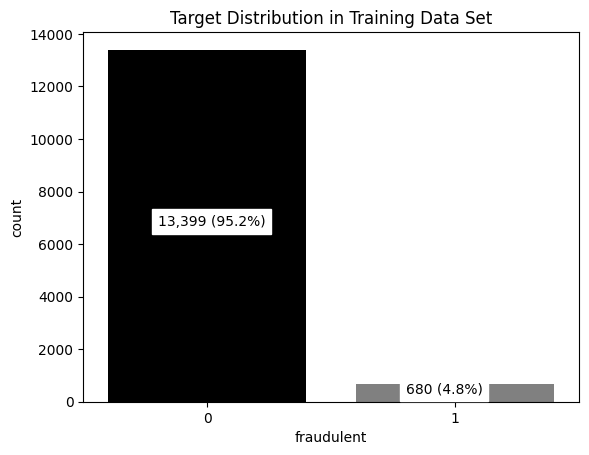

In [172]:
# Review the distribution of the target variable for the Training data set
train_y = pd.DataFrame(y_train, columns = [target])

target_distribution(data=train_y,
                    target=target,
                    title='Target Distribution in Training Data Set')

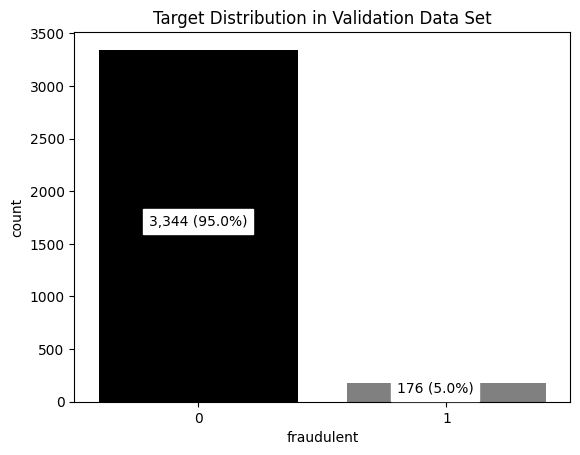

In [173]:
# Review the distribution of the target variable for the validation data set
validate_y = pd.DataFrame(y_test, columns = [target])

target_distribution(data=validate_y,
                    target=target,
                    title='Target Distribution in Validation Data Set')

# Rebalance Train Data

## Over-sampling: SMOTE
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

<img src="../Image%20Folder/Markdown%20Images/smote.png" 
        alt="Over-sampling: SMOTE" 
        style="display: block; margin: 0 auto" />



In [174]:
# Use SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority')

X_sm, y_sm = smote.fit_resample(X_train,y_train)

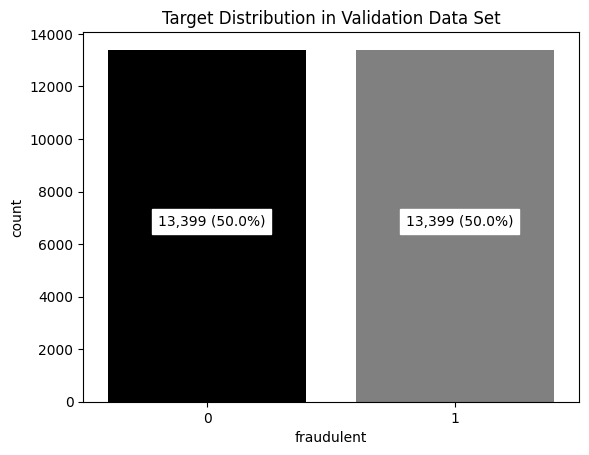

In [175]:
# Plot Target Variable fraudulent distribution.

sm_training_y = pd.DataFrame(y_sm, columns = [target])

target_distribution(data=sm_training_y,
                    target=target,
                    title='Target Distribution in Validation Data Set')

# Save Test / Train Datasets


In [179]:
# Save the data sets to pickle files
g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

X_test.to_pickle(g_drive + "X_test.pkl") 
y_test.to_pickle(g_drive + "y_test.pkl") 
X_train.to_pickle(g_drive + "X_train.pkl") 
y_train.to_pickle(g_drive + "y_train.pkl") 
X_sm.to_pickle(g_drive + "X_sm_train.pkl") # X_train after SMOTE
y_sm.to_pickle(g_drive + "y_sm_train.pkl") # y_train after SMOTE


# Data Preparation Complete
We are now ready to begin modeling our data.